In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.model_selection import ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import pandas as pd

import time
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import accuracy_score,f1_score,recall_score,make_scorer

In [ ]:
# Carregar o conjunto de dados penguin
dataset_name = 'penguins'
penguins = sns.load_dataset(dataset_name)
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## Pré-processamento

In [ ]:
# verifica balanceamento
species_values = penguins['species']
species_values.value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

In [ ]:
# verifica valores nulos
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [ ]:
# Remover valores nulos
penguins.dropna(inplace=True)
penguins.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

<Axes: >

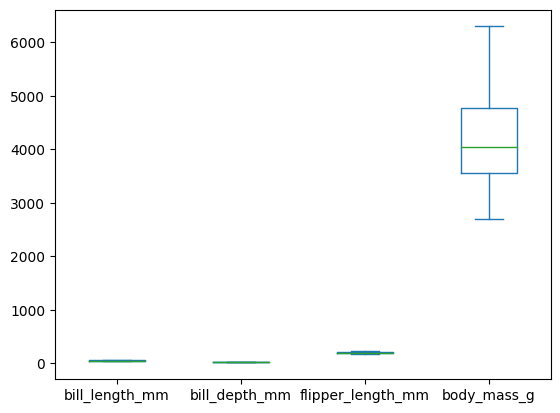

In [ ]:
# verifica outiliers
import matplotlib.pyplot as plt

penguins_data_numeric = penguins.drop(columns=['species', 'island', 'sex'])

penguins_data_numeric.plot(kind='box')

In [ ]:
# Calcular as estatísticas descritivas
estatisticas_descritivas = penguins.describe()

# Calcular o valor mínimo e máximo de cada atributo
minimos = penguins_data_numeric.min()
maximos = penguins_data_numeric.max()

# Exibir as estatísticas descritivas
print("Média:")
print(estatisticas_descritivas.mean())
print("\nDesvio Padrão:")
print(estatisticas_descritivas.std())
print("\nVariância:")
print(estatisticas_descritivas.var())
print("\nValor Mínimo:")
print(minimos)
print("\nValor Máximo:")
print(maximos)


Média:
bill_length_mm         75.845183
bill_depth_mm          54.791763
flipper_length_mm     193.872842
body_mass_g          3340.034107
dtype: float64

Desvio Padrão:
bill_length_mm        105.098164
bill_depth_mm         112.565291
flipper_length_mm      87.833230
body_mass_g          1999.914029
dtype: float64

Variância:
bill_length_mm       1.104562e+04
bill_depth_mm        1.267094e+04
flipper_length_mm    7.714676e+03
body_mass_g          3.999656e+06
dtype: float64

Valor Mínimo:
bill_length_mm         32.1
bill_depth_mm          13.1
flipper_length_mm     172.0
body_mass_g          2700.0
dtype: float64

Valor Máximo:
bill_length_mm         59.6
bill_depth_mm          21.5
flipper_length_mm     231.0
body_mass_g          6300.0
dtype: float64


In [ ]:
# Separar os atributos das classes
X = penguins.drop('species', axis=1)
y = penguins['species']

In [ ]:
# Definir colunas categóricas e numéricas
categorical_cols = ['island', 'sex']
numeric_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Aplicar labelEncoder para as colunas categóricas
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

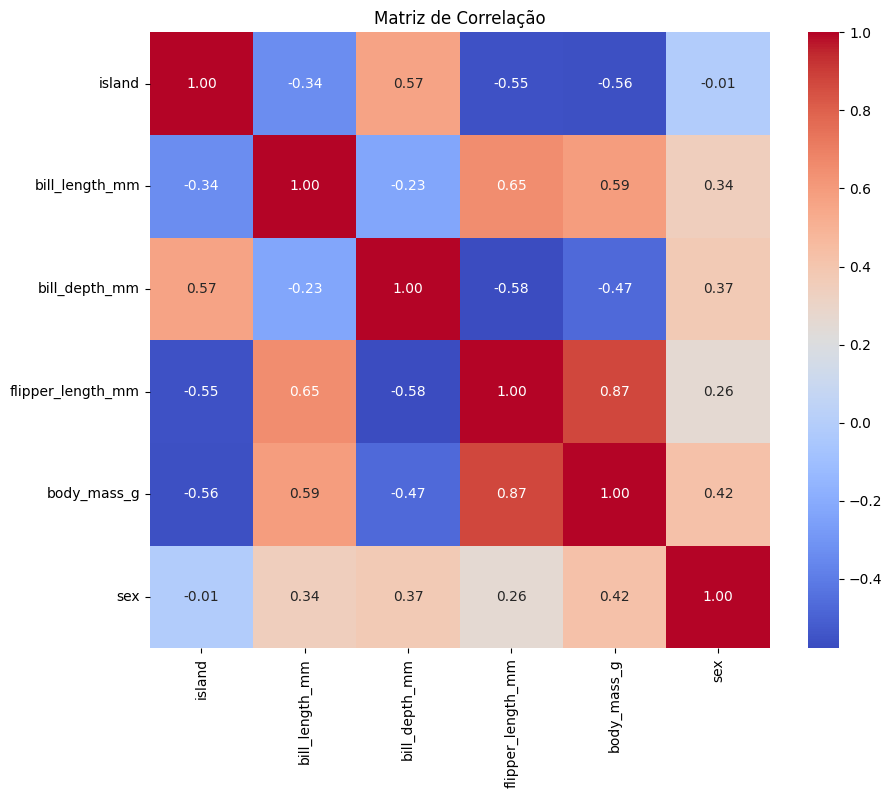

In [ ]:
# matriz de correlaçao

# Calcular a matriz de correlação para variáveis numéricas
correlacao = X.corr()
plt.figure(figsize=(10, 8))

# Criar o heatmap da matriz de correlação
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")

# Adicionar título ao heatmap
plt.title('Matriz de Correlação')
# Exibir o heatmap
plt.show()

## Balanceamento dos dados

In [ ]:
## balancear os dados para ver se melhora o resultado
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=10)
X_res, y_res = sm.fit_resample(X, y)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_res)
y_scaled = y_res

Selecionar algumas caracteristicas

In [ ]:
# selct k best

## Metodos


In [ ]:
# Definindo os parâmetros a serem testados
classifier = [
    (
        "SVM", 'SVM', SVC(),
        {
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': [0.01, 0.1, 1],
            'C': [1, 10, 100],
        }
    ),
]


In [ ]:
print(X_scaled.shape)
print(y_scaled.shape)

(438, 6)
(438,)


In [ ]:
list_models=[]

#mínimo 30 iterações
for run in range(30):
    for name, clf_name, clf, clf_param_grid in classifier:

      #instancia método de validação cruzada
      cv = model_selection.LeaveOneOut()

      #instancia o Grid Search: classificador, grade de parâmetros, validacao cruzada, score
      clf_gcv=model_selection.GridSearchCV(estimator=clf, param_grid=clf_param_grid, cv=cv, scoring=make_scorer(accuracy_score), n_jobs=-1, verbose=0)

      #atribui o tempo quando inicia o processo de divisão em treinamento e teste
      st = time.time()

      #divide treinameto e teste
      for train, test in cv.split(X_scaled):
          X_train, X_test = X_scaled[train], X_scaled[test]
          y_train, y_test = y_scaled[train], y_scaled[test]

      #treina
      clf_gcv.fit(X_train, y_train)

      #realiza a predição
      y_pred = clf_gcv.predict(X_test)

      #calcula o tempo final
      st = time.time()-st

      #armazena infromações em um dicionário
      l = {
      'DATASET'	: dataset_name						,
      'MODEL'		: clf_name						,
      'RUN'		: run							,
      'BEST_PARAMS'	: clf_gcv.best_params_			 		,
      'TIME'		: st							,
      'Y_TRUE'     	: y_test						,
      'Y_PRED'     	: y_pred						,
       'F1'     	: f1_score(y_test, y_pred, average='weighted')		,
      'ACCURACY'     	: accuracy_score(y_test, y_pred)			,
      'RECALL'     	: recall_score(y_test, y_pred, average='weighted')	,
		}

    #adiciona a cada rodada em uma lista
    list_models.append(l)

In [ ]:
aux = pd.DataFrame(list_models)

aux

,DATASET,MODEL,RUN,BEST_PARAMS,TIME,Y_TRUE,Y_PRED,F1,ACCURACY,RECALL
0,penguins,SVM,0,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",94.974205,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
1,penguins,SVM,1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",70.781823,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
2,penguins,SVM,2,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",72.957567,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
3,penguins,SVM,3,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",72.334806,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
4,penguins,SVM,4,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",71.490880,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
5,penguins,SVM,5,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",70.928206,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
6,penguins,SVM,6,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",72.388863,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
7,penguins,SVM,7,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",72.778218,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
8,penguins,SVM,8,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",70.928523,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0
9,penguins,SVM,9,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",71.846102,"437 Gentoo Name: species, dtype: object",[Gentoo],1.0,1.0,1.0


In [ ]:
aux['F1'].mean()

1.0

In [ ]:
aux['F1'].std()

0.0

In [ ]:
aux['ACCURACY'].mean()

1.0

In [ ]:
aux['ACCURACY'].std()

0.0

In [ ]:
aux['RECALL'].mean()

1.0

In [ ]:
aux['RECALL'].std()

0.0